# Compound Binds Gene Edge Prediction

This notebook is designed to take the next step moving from predicted sentences to edge predictions. After training the discriminator model, each sentences contains a confidence score for the likelihood of mentioning a relationship. Multiple relationships contain multiple sentences, which makes establishing an edge unintuitive. Is taking the max score appropiate for determining existence of an edge? Does taking the mean of each relationship make more sense? The answer towards these questions are shown below.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
total_candidates_df = (
    pd
    .read_table("../dataset_statistics/results/all_gig_candidates.tsv.xz")
    .sort_values("candidate_id")
)
total_candidates_df.head(2)

/home/danich1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/danich1/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,gene1_id,gene1_name,gene2_id,gene2_name,sources,n_sentences,hetionet,has_sentence,split,partition_rank,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
10815688,2796,GNRH1,2796,GNRH1,NaN,9310,0,1,3,0.415835,1.0,0.0,2,274809,Correlation between leuteinizing hormone respo...,20,25627
3285545,3976,LIF,3976,LIF,NaN,2732,0,1,3,0.117900,0.0,0.0,2,622251,The production of heterologous antibodies to t...,17,25628


In [3]:
sentence_prediction_df = (
    pd
    .read_table("input/all_sentence_pred.tsv.xz")
    .sort_values("candidate_id")
)
sentence_prediction_df.head(2)

/home/danich1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until


,candidate_id,pred
0,25627,0.023143
1,25628,0.000479


In [4]:
# DataFrame that combines likelihood scores with each candidate sentence
total_candidates_pred_df = (
    total_candidates_df[[
    "gene1_id", "gene1_name", 
    "gene2_id", "gene2_name", 
    "text", "hetionet",
    "candidate_id", "split"
    ]]
    .merge(sentence_prediction_df, on="candidate_id")
)

#total_candidates_pred_df.to_csv(
#    "output/combined_predicted_gig_sentences.tsv.xz", 
#    sep="\t", index=False, compression="xz"
#)

total_candidates_pred_df.head(2)

,gene1_id,gene1_name,gene2_id,gene2_name,text,hetionet,candidate_id,split,pred
0,2796,GNRH1,2796,GNRH1,Correlation between leuteinizing hormone respo...,0,25627,3,0.023143
1,3976,LIF,3976,LIF,The production of heterologous antibodies to t...,0,25628,3,0.000479


In [8]:
# DataFrame that groups gene mentions together and takes
# the max, median and mean of each group
grouped_candidates_pred_df=(
    total_candidates_pred_df
    .groupby(["gene1_id", "gene2_id"], as_index=False)
    .agg({
        "pred": ['max', 'mean', 'median'], 
        'hetionet': 'max',
        "gene1_name": 'first',
        "gene2_name": 'first',
        "split": 'first'
    })
)
grouped_candidates_pred_df.head(2)

gene1_id gene2_id      pred                     hetionet gene1_name  \
                          max      mean    median      max      first   
0        1        1  0.487505  0.128683  0.094391        0       A1BG   
1        1        2  0.033718  0.033718  0.033718        0       A1BG   

  gene2_name split  
       first first  
0       A1BG     4  
1        A2M     3

In [9]:
grouped_candidates_pred_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'gene1_name', 'gene2_name', 'split'] else col[0] 
    for col in grouped_candidates_pred_df.columns.values
]
grouped_candidates_pred_df.head(2)

,gene1_id,gene2_id,pred_max,pred_mean,pred_median,hetionet,gene1_name,gene2_name,split
0,1,1,0.487505,0.128683,0.094391,0,A1BG,A1BG,4
1,1,2,0.033718,0.033718,0.033718,0,A1BG,A2M,3


In [10]:
grouped_candidates_pred_df = (
    grouped_candidates_pred_df
    .query("split==5")
    .drop("split", axis=1)
)
grouped_candidates_pred_df.head(2)

,gene1_id,gene2_id,pred_max,pred_mean,pred_median,hetionet,gene1_name,gene2_name
67,2,2,0.950318,0.186167,0.062882,0,A2M,A2M
107,2,973,0.112824,0.069467,0.069467,0,A2M,CD79A


In [11]:
grouped_candidates_pred_df.hetionet.value_counts()

0    30852
1     1680
Name: hetionet, dtype: int64

In [12]:
performance_map = {}

In [14]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.pred_max,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.pred_max,
)

performance_map['max'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [15]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.pred_mean,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.pred_mean,
)

performance_map['mean'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [16]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.pred_median,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.pred_median,
)

performance_map['median'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

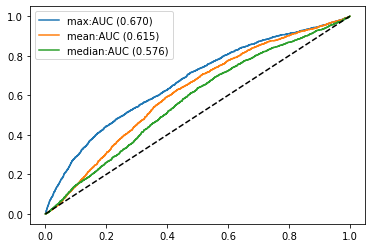

In [17]:
for key in performance_map:
    plt.plot(
        performance_map[key]['false_pos'], 
        performance_map[key]['true_pos'], 
        label=f"{key}:AUC ({auc(performance_map[key]['false_pos'], performance_map[key]['true_pos']):.3f})"
    )
plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.legend()
plt.show()

In [18]:
# https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = pd.np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 
roc_optimal = Find_Optimal_Cutoff(grouped_candidates_pred_df.hetionet.values, grouped_candidates_pred_df.pred_max)[0]
roc_optimal

/home/danich1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0.15994045

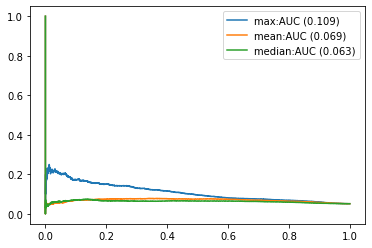

In [19]:
for key in performance_map:
    plt.plot(
        performance_map[key]['recall'], 
        performance_map[key]['precision'], 
        label=f"{key}:AUC ({auc(performance_map[key]['recall'], performance_map[key]['precision']):.3f})"
    )

plt.legend()
plt.show()

# Optimal PR-Cutoff

In [20]:
threshold_df = (
    pd.DataFrame(
        list(
            zip(
                performance_map['max']['precision'], 
                performance_map['max']['recall'], 
                performance_map['max']['pr_threshold']
            )
        ),
        columns=["precision", "recall", "pr_threshold"]
    )
    .sort_values("precision", ascending=False)
)
threshold_df.head(2)

,precision,recall,pr_threshold
32418,0.250000,0.0125,0.906598
32417,0.247059,0.0125,0.906542


In [21]:
#precision_thresholds = pd.np.linspace(0,1,num=5)
precision_thresholds = threshold_df.round(2).drop_duplicates("precision").precision.values

# Add the lowest precision rather than
# Keep it zero
precision_thresholds = (
    pd.np.where(
        precision_thresholds==0, 
        threshold_df.query("precision > 0").precision.min(), 
        precision_thresholds
    )
)

performance_records = []
for precision_cutoff in tqdm_notebook(precision_thresholds):

    cutoff = (
        threshold_df
        .query("precision>=@precision_cutoff")
        .pr_threshold
        .min()
    )
    
    values_added = (
        grouped_candidates_pred_df
        .query("pred_max >= @cutoff")
        .hetionet
        .value_counts()
    )
    
    series_keys = list(values_added.keys())
    for key in series_keys:
        performance_records.append(
           {  
               "edges": values_added[key], 
               "in_hetionet": "Existing" if key == 1 else "Novel", 
               "precision": precision_cutoff,
               "sen_cutoff": cutoff
           }
        )
   
    
edges_added_df = (
    pd
    .DataFrame
    .from_records(performance_records)
)
edges_added_df.head(10)

/home/danich1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


,edges,in_hetionet,precision,sen_cutoff
0,63,Novel,0.25,0.906598
1,21,Existing,0.25,0.906598
2,69,Novel,0.24,0.904841
3,22,Existing,0.24,0.904841
4,87,Novel,0.23,0.897680
5,26,Existing,0.23,0.897680
6,191,Novel,0.22,0.873789
7,54,Existing,0.22,0.873789
8,259,Novel,0.21,0.861675
9,69,Existing,0.21,0.861675


[None]

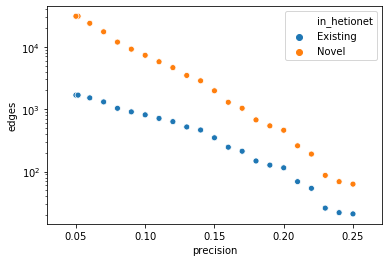

In [22]:
ax = sns.scatterplot(x="precision", y="edges", hue="in_hetionet", data=edges_added_df.sort_values("in_hetionet"))
ax.set(yscale="log")

In [24]:
edges_added_df.to_csv("output/precision_gig_edges_added.tsv", index=False, sep="\t")

# Optimal ROC Cutoff

In [25]:
(
    grouped_candidates_pred_df
    .query("pred_max > @roc_optimal")
    .sort_values("hetionet")
    .hetionet.value_counts()
)

0    11885
1     1033
Name: hetionet, dtype: int64

In [26]:
(
    grouped_candidates_pred_df
    .query("pred_max > @roc_optimal")
    .sort_values(["hetionet", "pred_max"], ascending=[True, False])
    .head(10)
)

,gene1_id,gene2_id,pred_max,pred_mean,pred_median,hetionet,gene1_name,gene2_name
607333,7157,2810,0.956390,0.252829,0.178693,0,TP53,SFN
618644,7299,7299,0.955107,0.350789,0.268351,0,TYR,TYR
67,2,2,0.950318,0.186167,0.062882,0,A2M,A2M
851521,79577,846,0.949936,0.934678,0.934678,0,CDC73,CASR
714571,10165,10165,0.948074,0.382813,0.271189,0,SLC25A13,SLC25A13
148890,1499,7490,0.945591,0.236648,0.146248,0,CTNNB1,WT1
300813,3552,3553,0.943410,0.091153,0.026806,0,IL1A,IL1B
511592,5979,673,0.942609,0.240136,0.105599,0,RET,BRAF
278212,3291,3291,0.940742,0.367798,0.127536,0,HSD11B2,HSD11B2
308794,3566,3566,0.937424,0.269356,0.151564,0,IL4R,IL4R
